In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Data Preprocessing
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

# Models
from keras import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
from keras.layers import (Input, Embedding, Dropout, LSTM, Conv2D, MaxPool2D,
                          Dense, Activation, RepeatVector, Flatten, Concatenate)
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

***

In [3]:
from utils.data import PATH_TO_DATA, GUIS_CODE, GUIS_SKETCH
from utils.data.image import get_preprocessed_img
from utils.data.sequence import tokenize_dsl_code
from utils.data.sets import (get_sketch_id_code_pair, init_sketch_id_code_map,
                             load_vocabulary, init_word2idx, init_idx2word)

***

In [4]:
demo_sketch_id = '00150311-A7AE-4804-8B7D-9273687B4FC0'

### Init Sketch to DSL Code map

In [5]:
sketch_id_code_map = init_sketch_id_code_map(GUIS_CODE)
print(sketch_id_code_map[demo_sketch_id])

header {
btn-inactive, btn-inactive, btn-inactive, btn-inactive
}
row {
single {
small-title, text, btn-orange
}
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}



### Load / Show the Sketch

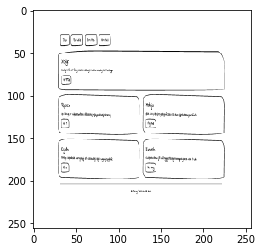

In [6]:
image = get_preprocessed_img(PATH_TO_DATA+demo_sketch_id+'.png')
plt.imshow(image);

***

## Create a Vocabulary

In [7]:
vocabulary = load_vocabulary('../vocabulary.txt')

In [8]:
len(vocabulary)

18

### Word2Idx, Idx2Word maps

In [9]:
word2idx = init_word2idx(vocabulary)
idx2word = init_idx2word(vocabulary)

In [10]:
word2idx

{',': 1,
 '0': 0,
 '<END>': 16,
 '<START>': 13,
 'btn-active': 15,
 'btn-green': 10,
 'btn-inactive': 8,
 'btn-orange': 9,
 'btn-red': 11,
 'double': 12,
 'header': 14,
 'quadruple': 6,
 'row': 7,
 'single': 17,
 'small-title': 4,
 'text': 5,
 '{': 2,
 '}': 3}

In [11]:
idx2word

{0: '0',
 1: ',',
 2: '{',
 3: '}',
 4: 'small-title',
 5: 'text',
 6: 'quadruple',
 7: 'row',
 8: 'btn-inactive',
 9: 'btn-orange',
 10: 'btn-green',
 11: 'btn-red',
 12: 'double',
 13: '<START>',
 14: 'header',
 15: 'btn-active',
 16: '<END>',
 17: 'single'}

***

## Max DSL Code Length

In [12]:
print('Total number of DSL Codes: {}'.format(len(sketch_id_code_map.values())))

Total number of DSL Codes: 1700


In [13]:
longets_code = max(
    sketch_id_code_map.values(), key=lambda x: len(tokenize_dsl_code(x)))

print('Longes code:')
print('=' * 30)
print()
print(longets_code)

Longes code:

header {
btn-inactive, btn-inactive, btn-inactive, btn-inactive
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}



In [14]:
max_code_length = len(tokenize_dsl_code(longets_code)) + 2

print('Max DSL Code Length: {}'.format(max_code_length))

Max DSL Code Length: 117


***

## Train/Dev/Test split

In [15]:
len(sketch_id_code_map)

1700

In [16]:
SPLIT = (.8, .1, .1)

In [17]:
items = list(sketch_id_code_map.items())
total_num = len(items)

borders = (
    int(total_num * SPLIT[0]),
    int(total_num * SPLIT[0]) + int(total_num * SPLIT[1]),
    int(total_num * SPLIT[0]) + int(total_num * SPLIT[1]) + int(
        total_num * SPLIT[2]),
)

train_sketch_id_code_map = dict(items[0:borders[0]])
dev_sketch_id_code_map = dict(items[borders[0]:borders[1]])
test_sketch_id_code_map = dict(items[borders[1]:borders[2]])

In [18]:
assert len(train_sketch_id_code_map) + len(dev_sketch_id_code_map) + len(
    test_sketch_id_code_map) == len(sketch_id_code_map)

In [19]:
print('Train Set size: {}'.format(len(train_sketch_id_code_map)))
print('Dev Set size: {}'.format(len(dev_sketch_id_code_map)))
print('Test Set size: {}'.format(len(test_sketch_id_code_map)))

Train Set size: 1360
Dev Set size: 170
Test Set size: 170


***

## Data Generator

In [20]:
# data generator, intended to be used in a call to model.fit_generator()


def data_generator(sketch_id_code_set, word2idx, batch_size, maxlen=max_code_length):
    X_img = []
    X_seq = []
    Y = []
    n = 0

    # loop for ever over images
    while True:
        for sketch_id, code in sketch_id_code_set.items():
            # load sketch
            sketch = get_preprocessed_img(PATH_TO_DATA+sketch_id+'.png')
            code = tokenize_dsl_code(code)
            
            for i in range(len(code)):
                X_img.append(sketch)

                x_seq = ['<START>'] + code[:i]
                x_seq = [word2idx[word] for word in x_seq]
                X_seq.append(x_seq)

                Y.append(word2idx[code[i]])
                
                n += 1
                # yield the batch data
                if n == batch_size:
                    X_seq = pad_sequences(X_seq, maxlen=maxlen, padding='post')

                    # One-hot
                    Y = [to_categorical(idx, len(vocabulary)) for idx in Y]

                    yield [[np.array(X_img), np.array(X_seq)], np.array(Y)]

                    X_img = []
                    X_seq = []
                    Y = []
                    n = 0
            
            X_img.append(sketch)
            
            x_seq = ['<START>'] + code
            x_seq = [word2idx[word] for word in x_seq]
            X_seq.append(x_seq)

            Y.append(word2idx['<END>'])
            
            n += 1
            # yield the batch data
            if n == batch_size:
                X_seq = pad_sequences(X_seq, maxlen=maxlen, padding='post')

                # One-hot
                Y = [to_categorical(idx, len(vocabulary)) for idx in Y]
                
                yield [[np.array(X_img), np.array(X_seq)], np.array(Y)]

                X_img = []
                X_seq = []
                Y = []
                n = 0


***

# Sketch Encoder (ConvNet)

In [22]:
SKETCH_EMBEDDING_DIM = 1024

In [25]:
img_in = Input((256, 256, 3), name='image_input')

x = Conv2D(32, (3, 3), activation='relu', padding='valid', name='conv_32')(img_in)
x = MaxPool2D(pool_size=(2, 2), name='maxpool_1')(x)
x = Dropout(0.3, name='dropout_1')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='valid', name='conv_64')(x)
x = MaxPool2D(pool_size=(2, 2), name='maxpool_2')(x)
x = Dropout(0.3, name='dropout_2')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='valid', name='conv_128')(x)
x = MaxPool2D(pool_size=(2, 2), name='maxpool_3')(x)
x = Dropout(0.3, name='dropout_3')(x)

x = Flatten(name='flatten')(x)

x = Dense(1024, activation='relu', name='dense_relu_1')(x)
x = Dropout(0.3, name='dense_dropout_1')(x)

x = Dense(SKETCH_EMBEDDING_DIM, activation='relu', name='dense_relu_2')(x)
x = Dropout(0.3, name='dense_dropout_2')(x)

x = RepeatVector(max_code_length, name='repeat')(x)

sketch_encoder = Model(img_in, x, name='sketch_encoder')

In [26]:
# plot_model(sketch_encoder, to_file='./model_plots/t_looks/sketch_encoder.png', show_shapes=True, show_layer_names=True)

print(sketch_encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 256, 256, 3)       0         
_________________________________________________________________
conv_32 (Conv2D)             (None, 254, 254, 32)      896       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv_64 (Conv2D)             (None, 125, 125, 64)      18496     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 62, 64)        0         
__________

***

# Sequence Encoder (LSTM)

In [27]:
SEQUENCE_EMBEDDING_DIM = 128

In [28]:
# Sequence Input
seq_in = Input((max_code_length,), name='sequence_input')

# Embeddings
x = Embedding(
    len(vocabulary),
    50,
    input_length=max_code_length,
    mask_zero=True,
    name='embeddings'
)(seq_in)
    
# Dropout
x = Dropout(0.5, name='embeddings_dropout')(x)

# Sequence Encoder
x = LSTM(SEQUENCE_EMBEDDING_DIM, return_sequences=True, return_state=False, name='lstm_encoder_1')(x)
x = LSTM(SEQUENCE_EMBEDDING_DIM, return_sequences=True, return_state=False, name='lstm_encoder_2')(x)

sequence_encoder = Model(inputs=seq_in, outputs=x, name='sequence_encoder')


In [29]:
# plot_model(sequence_encoder, to_file='./model_plots/t_looks/sequence_encoder.png', show_shapes=True, show_layer_names=True)

print(sequence_encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence_input (InputLayer)  (None, 117)               0         
_________________________________________________________________
embeddings (Embedding)       (None, 117, 50)           900       
_________________________________________________________________
embeddings_dropout (Dropout) (None, 117, 50)           0         
_________________________________________________________________
lstm_encoder_1 (LSTM)        (None, 117, 128)          91648     
_________________________________________________________________
lstm_encoder_2 (LSTM)        (None, 117, 128)          131584    
Total params: 224,132
Trainable params: 224,132
Non-trainable params: 0
_________________________________________________________________
None


***

# Decoder (LSTM)

In [30]:
DECODER_NUM_HIDDEN_NEURONS = 512

In [31]:
sketch_emb_in = Input((max_code_length, SKETCH_EMBEDDING_DIM), name='sketch_emb_input')
sequence_emb_in = Input((max_code_length, SEQUENCE_EMBEDDING_DIM), name='sequence_emb_input')

x = Concatenate(name='merger')([sketch_emb_in, sequence_emb_in])

x = LSTM(DECODER_NUM_HIDDEN_NEURONS, return_sequences=True, return_state=False, name='lstm_decoder_1')(x)
x = LSTM(DECODER_NUM_HIDDEN_NEURONS, return_sequences=False, return_state=False, name='lstm_decoder_2')(x)
x = Dense(len(vocabulary), activation='softmax')(x)

sequence_decoder = Model([sketch_emb_in, sequence_emb_in], x)

In [32]:
# plot_model(sequence_decoder, to_file='./model_plots/t_looks/sequence_decoder.png', show_shapes=True, show_layer_names=True)

print(sequence_decoder.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sketch_emb_input (InputLayer)   (None, 117, 1024)    0                                            
__________________________________________________________________________________________________
sequence_emb_input (InputLayer) (None, 117, 128)     0                                            
__________________________________________________________________________________________________
merger (Concatenate)            (None, 117, 1152)    0           sketch_emb_input[0][0]           
                                                                 sequence_emb_input[0][0]         
__________________________________________________________________________________________________
lstm_decoder_1 (LSTM)           (None, 117, 512)     3409920     merger[0][0]                     
__________

***

# Model

In [33]:
sketch_emb = sketch_encoder(img_in)
seq_emb = sequence_encoder(seq_in)
out = sequence_decoder([sketch_emb, seq_emb])

# Build the model
model = Model(inputs=[img_in, seq_in], outputs=out, name='model')


### Visualize the model

In [34]:
# plot_model(model, to_file='./model_plots/t_looks/model.png', show_shapes=True, show_layer_names=True)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
sequence_input (InputLayer)     (None, 117)          0                                            
__________________________________________________________________________________________________
sketch_encoder (Model)          (None, 117, 1024)    119108672   image_input[0][0]                
__________________________________________________________________________________________________
sequence_encoder (Model)        (None, 117, 128)     224132      sequence_input[0][0]             
__________________________________________________________________________________________________
model_1 (M

***

# Inference

In [35]:
def greedy_search_inference(sketch, maxlen=max_code_length):
    i = 0
    target_seq = np.zeros((1, max_code_length))
    target_seq[0, i] = word2idx['<START>']
    i+=1

    stop_condition = False
    decoded_tokens = []

    while not stop_condition:
        output_tokens = model.predict([np.expand_dims(sketch, 0), target_seq])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens)
        sampled_word = idx2word[sampled_token_index]
        decoded_tokens.append(sampled_word)

        # Exit condition
        if (sampled_word == '<END>' or len(decoded_tokens) >= maxlen):
            stop_condition = True
        
        if not stop_condition:
            target_seq[0, i] = sampled_token_index
            i+=1

    return ' '.join(decoded_tokens)

In [36]:

greedy_search_inference(get_preprocessed_img(PATH_TO_DATA+demo_sketch_id+'.png'))

'btn-green btn-green btn-green btn-green btn-green btn-green btn-green text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text'

***

## Run Train

### Callbacks

In [37]:
filepath="weights/t_looks_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=True)

def on_epoch_end(epoch, logs):
    if epoch % 5 == 0:
        print()
        print('Sampled:')
        print('='*30)
        print(greedy_search_inference(get_preprocessed_img(
            PATH_TO_DATA+np.random.choice(list(dev_sketch_id_code_map.keys()))+'.png'
        )))
        print()
        print()

lambda_cb = LambdaCallback(on_epoch_end=on_epoch_end)

callbacks = [checkpoint, lambda_cb]

In [52]:
model.load_weights('./weights/t_looks_weights.hdf5')

model.compile(Adam(1e-4), loss='categorical_crossentropy')

In [53]:
batch_size = 64
steps = len(train_sketch_id_code_map) // batch_size

model.fit_generator(
    data_generator(train_sketch_id_code_map, word2idx, batch_size),
    steps_per_epoch=steps,
    epochs=1e3,
    verbose=True,
    callbacks=callbacks,
)

Epoch 1/100
21/21 [==============================] - 46s 2s/step - loss: 0.0800

Epoch 00001: saving model to weights/t_looks_weights.hdf5

Sampled:
header header { { , , , } } row { double { small-title , text , btn-orange } double { small-title , text , btn-orange } } <END>


Epoch 2/100
21/21 [==============================] - 33s 2s/step - loss: 0.0796

Epoch 00002: saving model to weights/t_looks_weights.hdf5
Epoch 3/100
21/21 [==============================] - 33s 2s/step - loss: 0.0810

Epoch 00003: saving model to weights/t_looks_weights.hdf5
Epoch 4/100
21/21 [==============================] - 33s 2s/step - loss: 0.0737

Epoch 00004: saving model to weights/t_looks_weights.hdf5
Epoch 5/100
21/21 [==============================] - 33s 2s/step - loss: 0.0801

Epoch 00005: saving model to weights/t_looks_weights.hdf5
Epoch 6/100


KeyboardInterrupt: 

***

## Dev

header header { { , , , } } row { double { small-title , text , btn-orange } double { small-title , text , btn-orange } } <END>


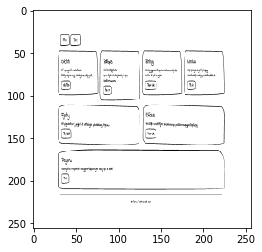

In [54]:
sketch_id = np.random.choice(list(dev_sketch_id_code_map.keys()))
sketch = get_preprocessed_img(PATH_TO_DATA+sketch_id+'.png')

plt.imshow(sketch);
print(greedy_search_inference(sketch))